<a href="https://colab.research.google.com/github/deepbas/ADC2023-baseline/blob/main/Copy_of_informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

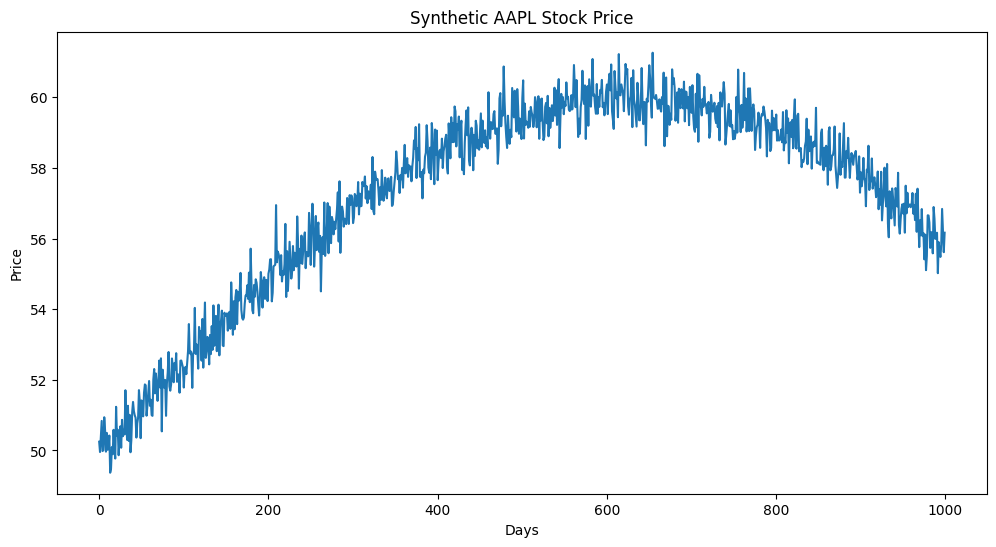

((663, 10, 1), (663,), (327, 10, 1), (327,))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Generate synthetic AAPL stock data
np.random.seed(42)
n = 1000  # Number of data points
t = np.linspace(0, 4*np.pi, n)
y = 50 + 10 * np.sin(0.2 * t) + 0.5 * np.random.normal(size=n)

# Create a DataFrame
df = pd.DataFrame({'price': y})

# Plot the synthetic stock price data
plt.figure(figsize=(12, 6))
plt.plot(df['price'])
plt.title('Synthetic AAPL Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare data for LSTM
look_back = 10  # Number of previous time steps to use as input variables to predict the next time period
n_features = 1  # Single feature (price)

# Convert to supervised learning problem
X, y = [], []
for i in range(len(df_scaled) - look_back):
    X.append(df_scaled[i:i+look_back, 0])
    y.append(df_scaled[i + look_back, 0])
X, y = np.array(X), np.array(y)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], n_features))

# Train-test split
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Attention, Concatenate

# Define the input shape
input_layer = Input(shape=(look_back, n_features))

# Encoder
encoder_lstm = LSTM(50, return_sequences=True)(input_layer)
attention_output = Attention(use_scale=True)([encoder_lstm, encoder_lstm])

# Decoder
decoder_lstm = LSTM(50, return_sequences=True)(attention_output)
flatten_layer = Flatten()(decoder_lstm)
output_layer = Dense(1)(flatten_layer)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model architecture
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 10, 50)               10400     ['input_1[0][0]']             
                                                                                                  
 attention_2 (Attention)     (None, 10, 50)               1         ['lstm_2[0][0]',              
                                                                     'lstm_2[0][0]']              
                                                                                                  
 lstm_3 (LSTM)               (None, 10, 50)               20200     ['attention_2[0][0]']     

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)


Epoch 1/100
19/19 [==============================] - 4s 40ms/step - loss: 0.1558 - val_loss: 0.0097
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.0055
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 8/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 9/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 10/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_original, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")


11/11 [==============================] - 1s 2ms/step
Mean Squared Error on Test Set: 0.35454820274750987
